In [ ]:
import pandas as pd
import openpyxl, xlrd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import np_utils
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path2 = "/content/drive/MyDrive/Colab Notebooks/radiomics_data_full.csv"
print("load file: ", file_path2)
df = pd.read_csv(file_path2)
df.dropna(inplace=True)

load file:  /content/drive/MyDrive/Colab Notebooks/radiomics_data_full.csv


In [ ]:
df.describe()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_JointAverage,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,...,wavelet-LLL_glrlm_LowGrayLevelRunEmphasis,wavelet-LLL_glrlm_RunEntropy,wavelet-LLL_glrlm_RunLengthNonUniformity,wavelet-LLL_glrlm_RunLengthNonUniformityNormalized,wavelet-LLL_glrlm_RunPercentage,wavelet-LLL_glrlm_RunVariance,wavelet-LLL_glrlm_ShortRunEmphasis,wavelet-LLL_glrlm_ShortRunHighGrayLevelEmphasis,wavelet-LLL_glrlm_ShortRunLowGrayLevelEmphasis,wavelet-LLL_glszm_GrayLevelNonUniformity,wavelet-LLL_glszm_GrayLevelNonUniformityNormalized,wavelet-LLL_glszm_GrayLevelVariance,wavelet-LLL_glszm_HighGrayLevelZoneEmphasis,wavelet-LLL_glszm_LargeAreaEmphasis,wavelet-LLL_glszm_LargeAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance,wavelet-LLL_gldm_DependenceEntropy,wavelet-LLL_gldm_DependenceNonUniformity,wavelet-LLL_gldm_DependenceNonUniformityNormalized,wavelet-LLL_gldm_DependenceVariance,wavelet-LLL_gldm_GrayLevelNonUniformity,wavelet-LLL_gldm_GrayLevelVariance,wavelet-LLL_gldm_HighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceEmphasis,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,pEMVI_review
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,9.600000e+01,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,9.600000e+01,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,9.600000e+01,9.600000e+01,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,9.600000e+01,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.719166,0.508607,21.499881,42.028163,43.071978,44.105881,38.770730,49.158253,14138.658420,29.130069,0.458315,6292.041441,0.527413,14192.187501,-9.051187,16.562081,1.306523e+09,0.959467,12.216051,6.463140,72.313895,8.272707,2.451907,0.501498,-28.708604,101.022499,5.241657,302.691837,1.166959,1.

In [ ]:
print(df.shape)
print(df.columns)

(96, 1133)
Index(['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength',
       ...
       'wavelet-LLL_gldm_GrayLevelVariance',
       'wavelet-LLL_gldm_HighGrayLevelEmphasis',
       'wavelet-LLL_gldm_LargeDependenceEmphasis',
       'wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis',
       'wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis',
       'wavelet-LLL_gldm_LowGrayLevelEmphasis',
       'wavelet-LLL_gldm_SmallDependenceEmphasis',
       'wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis',
       'wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis', 'pEMVI_review'],
      dtype='object', length=1133)


In [ ]:
## Data preparation

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop(['pEMVI_review'], axis = 1).values
Y = df['pEMVI_review']

X = StandardScaler().fit_transform(X)

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.4, random_state = 101)

# Feature Selection Techniques
1.   LR with L1 penalty (LASSO)

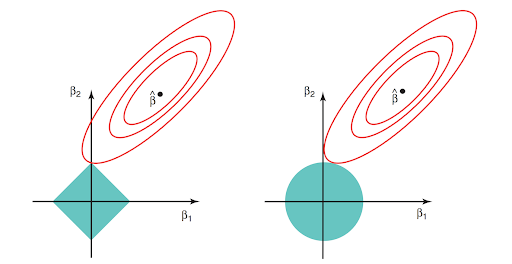





In [ ]:
from sklearn.linear_model import LogisticRegression

print("Computing regularization path using the coordinate descent lasso...")
lasso = LogisticRegression(penalty='l1',solver='liblinear', C=0.4, verbose=1).fit(X_Train, Y_Train)

Computing regularization path using the coordinate descent lasso...
[LibLinear]

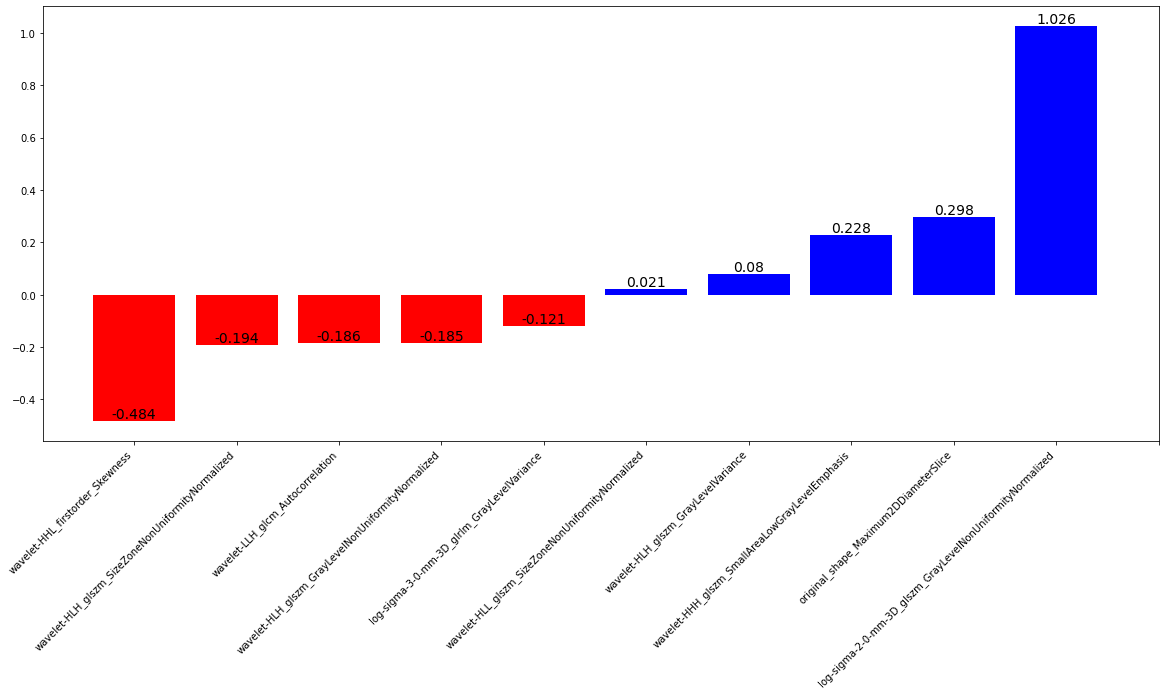

In [ ]:
def feature_plot(classifier, feature_names, top_features=5):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.figure(figsize=(20, 8))
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1 + 2 * top_features), feature_names[top_coefficients], rotation=45, ha='right')
 for i, v in enumerate(np.arange(2 * top_features)):
     plt.text(v,coef[top_coefficients][i], round(coef[top_coefficients][i],3), fontsize=14, horizontalalignment='center', verticalalignment='bottom')
 plt.show()

feature_plot(lasso, df.drop(['pEMVI_review'], axis = 1).columns.values)

# Feature Selection Techniques
2.   Linear SVM with L1 penalty (L1 based SVM)

> 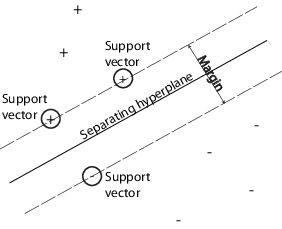

[LibLinear]

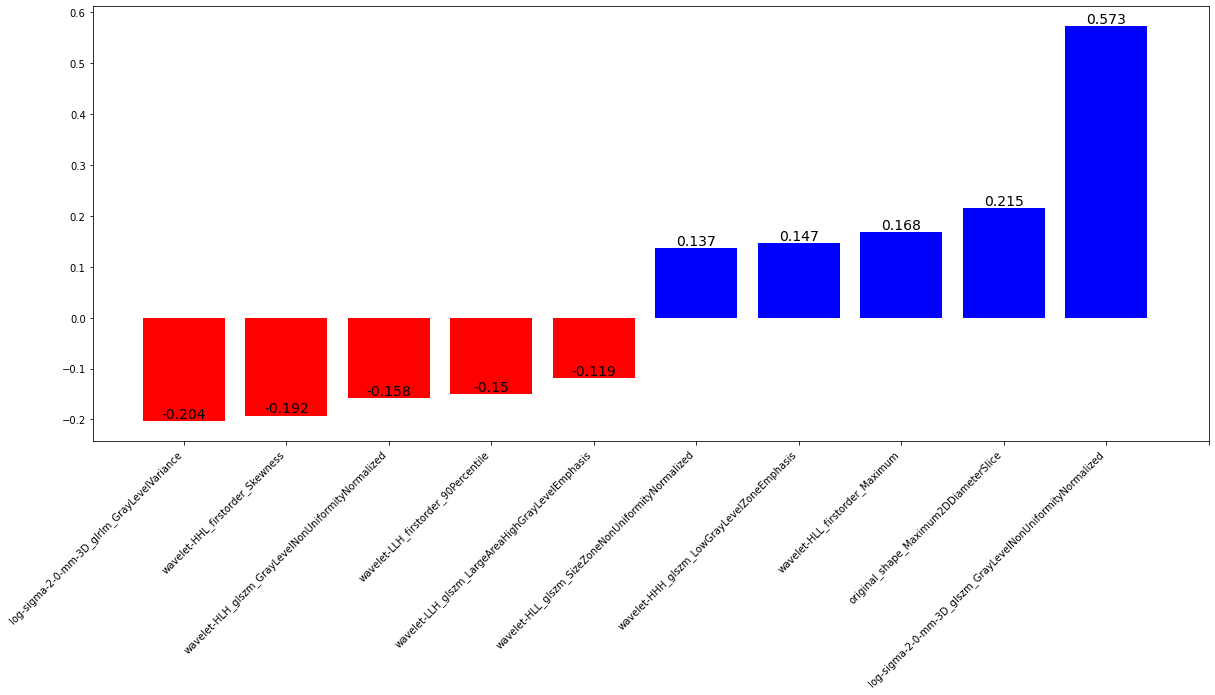

In [ ]:
from sklearn.svm import LinearSVC
trainedsvm = LinearSVC(C=0.2, penalty='l1', dual= False, verbose=1).fit(X_Train, Y_Train)
feature_plot(trainedsvm, df.drop(['pEMVI_review'], axis = 1).columns.values)

# Classification Techniques

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from itertools import product
import itertools

def plot_confusion_matrix(cm, classes=["0", "1"], title="",
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' +title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tick_params(axis='both', which='major', labelsize=16)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=16,
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

In [ ]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(lasso, threshold=0.1, max_features=10, prefit=True)
X_Train_new = selector.transform(X_Train)
X_Test_new = selector.transform(X_Test)
X_Test_new.shape

(39, 8)

[[19  8]
 [ 8  4]]
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        27
         1.0       0.33      0.33      0.33        12

    accuracy                           0.59        39
   macro avg       0.52      0.52      0.52        39
weighted avg       0.59      0.59      0.59        39



<Figure size 432x288 with 0 Axes>

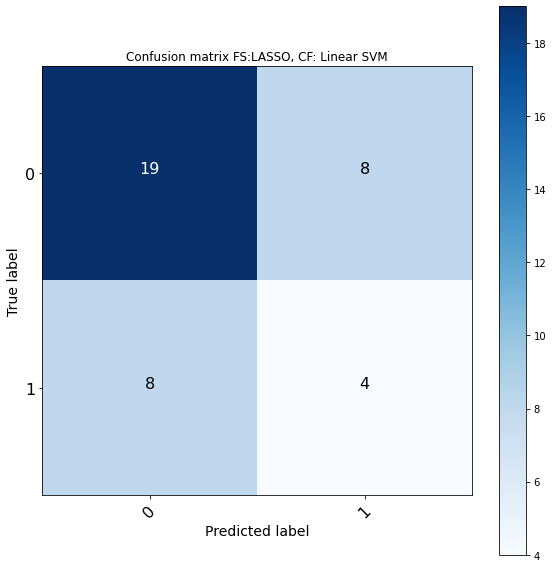

In [ ]:
reduced_model = LinearSVC(C=0.2, penalty='l1', dual= False).fit(X_Train_new, Y_Train)
#reduced_model = LogisticRegression(penalty='l1',solver='liblinear', C=0.2, verbose=1).fit(X_Train_new, Y_Train)
predictionlasso = reduced_model.predict(X_Test_new)
print(confusion_matrix(Y_Test,predictionlasso))
print(classification_report(Y_Test,predictionlasso))

cm_plot = confusion_matrix(Y_Test,predictionlasso)

plt.figure()
plot_confusion_matrix(cm_plot, title = 'FS:LASSO, CF: Linear SVM')

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_Test, predictionlasso)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_Test.ravel(), predictionlasso.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<Figure size 432x288 with 0 Axes>

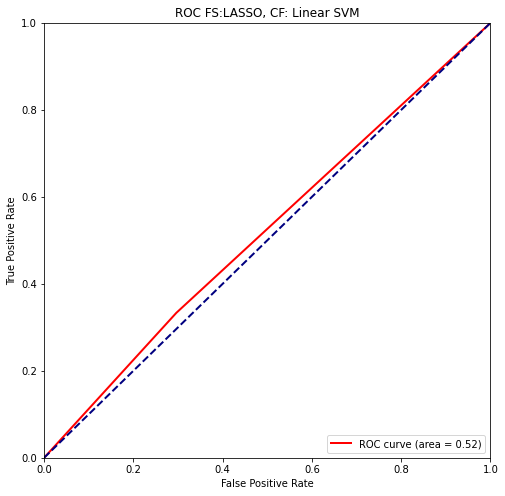

In [ ]:
plt.figure()
lw = 2
plt.figure(figsize=(8,8))
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC FS:LASSO, CF: Linear SVM')
plt.legend(loc="lower right")
plt.show()

In [ ]:
selector = SelectFromModel(trainedsvm, threshold=0.1, max_features=10, prefit=True)
X_Train_new = selector.transform(X_Train)
X_Test_new = selector.transform(X_Test)
X_Test_new.shape

(39, 10)

[[20  7]
 [ 7  5]]
              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74        27
         1.0       0.42      0.42      0.42        12

    accuracy                           0.64        39
   macro avg       0.58      0.58      0.58        39
weighted avg       0.64      0.64      0.64        39



<Figure size 432x288 with 0 Axes>

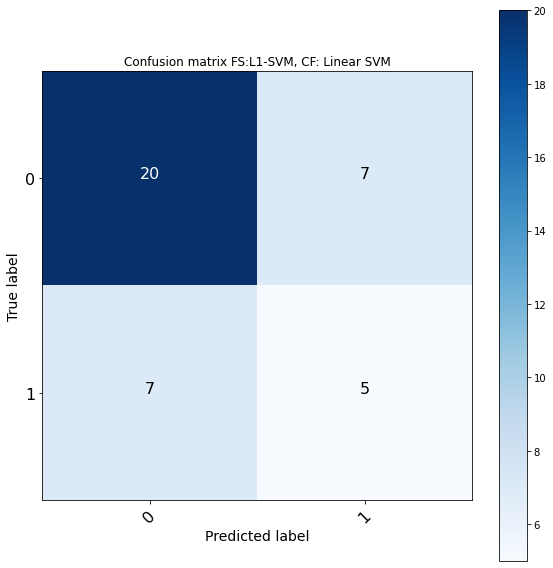

In [ ]:
reduced_model = LinearSVC(C=0.2, penalty='l1', dual= False).fit(X_Train_new, Y_Train)
predictionsvm = reduced_model.predict(X_Test_new)
print(confusion_matrix(Y_Test,predictionsvm))
print(classification_report(Y_Test,predictionsvm))

cm_plot = confusion_matrix(Y_Test,predictionsvm)

plt.figure()
plot_confusion_matrix(cm_plot, title = 'FS:L1-SVM, CF: Linear SVM')

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_Test, predictionsvm)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_Test.ravel(), predictionsvm.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<Figure size 432x288 with 0 Axes>

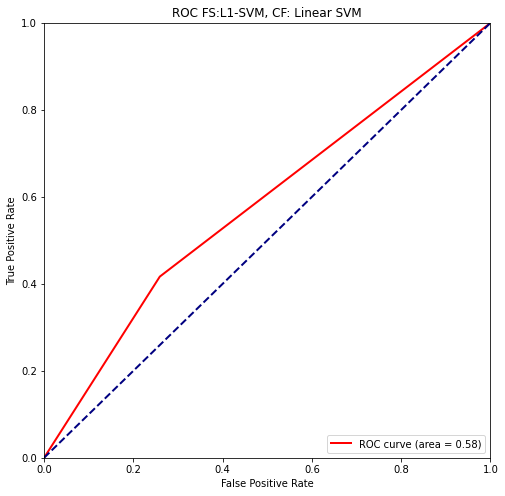

In [ ]:
plt.figure()
lw = 2
plt.figure(figsize=(8,8))
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC FS:L1-SVM, CF: Linear SVM')
plt.legend(loc="lower right")
plt.show()